# Condition numbers and regularization

# Introduction

This individual problem set has three aims:
learn to fi􏰀nd problematic data (multicollinearity) using condition numbers
􏰅see how Ridge and Lasso regressions are more stable in case of ill-conditioned data 􏰅 
learn to manually create design matrices for a survey data set.

We return here to the World Value Survey data, a large survey with ∼90k observations and 430 variables. Your task is to compile a large number of variables into a design matrix. The process easily leads to multicollinearity which you have to detect using condition numbers.
Thereafter we over􏰀t, but as this is a fairly large dataset, we only achieve this by selecting a small subsample of the data. You can see that over􏰀tting is often related to large condition numbers, and may lead to linear regression validation RMSE to be ridiculously large. But Ridge and Lasso can handle the situation much better.
When reasonably coded, the code should run fast (∼30s), except the stepwise condition number pro- cedure (∼10min). So you may want to be careful and not run that code too often.
Please submit a) your code (notebooks, rmd, whatever) and b) the results in a 􏰀nal output form (html or pdf).

# World Values Survey

World Value Survey (WVS) is a large survey, conducted in many countries simultaneously. It revolves around public opinion about traditions, economy, politics, life and other things. It is recommended you to consult the offi􏰄cial questionnaire (uploaded in canvas/􏰀les/wvs).
In this task the central question is V23: 􏰁All things considered, how satis􏰀ed are you with your life as a whole these days?􏰂 with answers ranging between 1 (completely dissatis􏰀ed) and 10 (completely satis􏰀ed). We are going to model this variables using linear regression.

# 1 Explore and clean the data

First, let's load data and take a closer look at it.

In [129]:
#importing packages
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os
from scipy import stats
from scipy import *
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import seaborn as sns

In [130]:
path = os.getcwd()
print(path)
data= pd.read_csv('../data/wvs.csv.bz2', sep='\t')

/Users/anjalisingh/Desktop/Winter 2020/data


In [131]:
data.head(5)
data.shape
#data.columns

(90350, 328)


1. Browse the WVS documentation and make sure you are familiar with coding of the variable V23. Note: you also have to consult the codebook to understand all the missings and how to remove those.

Values 1-10 range from completely dissatisfied to completely satisfied. Values -1 to -5 are inappropriate values and we need ot remove those.

2. Load the data. Remove all the missing observations of V23. I mean all the missings, including the valid numeric codes that denote missing/invalid answers.

In [132]:
#removing the missing values from V23
data = data[data['V23']>0]

Now make a table (or a plot) of diff􏰃erent answers. What is the mean satisfaction level on this planet? How large a proportion of people are at 6 or more satis􏰀ed?

Text(0.5, 1.0, 'Count of satisfaction level on this planet')

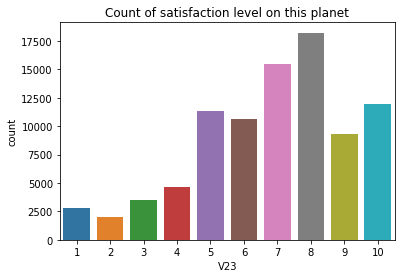

In [133]:
#plot of V23 and different answers
sns.countplot(x="V23", data=data).set_title("Count of satisfaction level on this planet")

In [134]:
data['V23'].mean()

6.8290316471911865

The mean satisfaction level on this planet is 6.829

In [135]:
len(data[data['V23'] >5])/len(data['V23'])*100

73.03472168072095

73.034% of the people are at 6 or more satisfied

# 2 Create the Design Matrix


Now it is time to make the data suitable for a regression model. So far we have either used R-style formulas, or fed data into a ML model directly without much preparatory work. Now it is time to construct the design matrix manually. In case of linear regression, the design matrix is the data matrix that will be directly fed into the formula (X􏰫 · X)−1X􏰫y, or any function that uses this or another similar formula. Design matrix can also be fed directly into other kind of models, such as logistic regression or decision tree. Design matrix is also needed by various libraries, in particular sklearn's LinearRegression, Ridge, and Lasso. There is an example of how to create a design matrix in the lecture notes, Section 2.1.7.

Your task is to add the variables to the design matrix, one-by-one, and each time doing the necessary encoding if appropriate.

Many variables are categorical. For instance, variable V2, country, is numeric with di􏰨erent numbers representing di􏰨erent countries. So in essence it is a categorical variable where categories are coded as numbers. The same is true for V80, most serious problem in the world. You should convert such variables to dummies (do your still remember pd.get_dummies?) and remove the original variable. But don't forget to remove missings!

A large number of variables contain ordered values instead. For instance, V55 asks how much choice do you feel do you have over your life. The answers range from 1 (no choice at all) to 10 (a great deal of choice). We treat these as numeric response. Although, strictly speaking not correct, the model would be too messy if we were creating a category for each response. However, the missings (-5: inapplicable, -4: not asked etc) are not ordered in any meaningful sense. Hence your task is to remove missings.


Note that many variables, e.g. v74b (important to help people nearby) and v90 (signing petition), contain a very large number of missings, and hence you essentially lose all your data if you include such variables. So you should remove such variables and replace with others that have more valid answers.
Was it clear? Good. Enough of talk, let's dive into the real thing.

1. Create your outcome variable y out of life satisfaction V23 (remove missings!)

In [136]:
#after removing missing values
y = data.V23

2. Create a design matrix that contains at least 100 variables from the WVS data. Your selected variables should contain at least a few categorical ones, such as V2 country. In each case:
(a) remove missing observations
(b) convert categorical variable to dummies if appropriate. Don't forget to drop the reference category.
This will result in a large amount of code that is essentially copy-paste, but not exactly. It is a little bit tedious to do though. Think about options to make it more automatic but... hint: there are no good options...
Note that when converting 100 variables into a design matrix, the latter may end up with many more columns.

Keep in mind that you end up deleting quite a few observations, everything that contains missings in any of your selected variables.

In [137]:
data.describe()

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,MN_228S8,MN_229A,MN_230A,MN_233A,MN_237B1,MN_249A1,MN_249A3,I_RELIGBEL,I_NORM1,I_VOICE1
count,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,...,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,89771.000000,85267.000000,88207.000000,85516.000000
mean,467.722260,1.095376,1.663566,1.856011,2.548652,1.471945,1.836595,1.834200,2.078578,1.475944,...,-3.354246,-3.447528,-3.578416,-3.514676,-3.820599,-3.513585,-3.521271,0.318095,0.463580,0.333475
std,248.409724,0.401337,0.773381,0.908102,1.105639,0.944288,1.111566,0.788411,0.875354,0.505013,...,1.956790,1.660353,1.412735,1.674569,0.711134,1.512512,1.499672,0.465739,0.498675,0.315871
min,12.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-5.000000,-5.000000,0.000000,0.000000,0.000000
25%,276.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,0.000000,0.000000
50%,434.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,0.000000,0.330000
75%,702.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,1.000000,1.000000,0.660000
max,887.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,...,4.000000,2.000000,2.000000,5.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000


We are going to check for the percentage of missing values and removing all the columns where the percentage is greater than 4%. 

In [138]:
good_cols = []
for col in list(data.columns):
    pct_of_missingness = len(data[data[col] < 0])/len(data)*100
    #print(col, len(data[data[col] < 0])/len(data)*100)
    if pct_of_missingness < 4:
        good_cols.append(col)
        #print(col, len(data[data[col] < 0])/len(data)*100)

len(good_cols)

124

In [139]:
#creating the dataframe after removing the columns with percentage of missing values greater than 4.
design_frame = data[good_cols]

In [140]:
design_frame.shape

(89771, 124)

In [141]:
#removing the rows that have missing values that are encoded. 
clean_design = design_frame.replace(to_replace = [-1,-2,-3,-4,-5],value = np.nan)
clean_design = clean_design.dropna()

In [142]:
clean_design.shape

(45202, 124)

We end up with 45202 rows and 124 columnns before creating dummies of the categorical variable. 

We are going to create dummies for the categorical variables V2,V24,V57,V80 and V83.

In [143]:
clean_design_dummy = pd.get_dummies(clean_design, columns = ['V2','V24','V57','V80','V83'],drop_first=True)

In [144]:
clean_design_dummy.shape

(45202, 181)

The final dataframe that is going to be converted to the matrix has 45202 rows and 181 columns. 

In [145]:
#creating the final design matrix
clean_design_matrix = clean_design_dummy.as_matrix()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# 3 Condition numbers

The next task is to compute the condition number of your design matrix. It will quite likely be way too big: some of the answers may be highly correlated, you may forget to drop the reference category, the reference category you drop may have no observations, there may be several variables that contain exactly the same information... But we want to know which variables are the culprits. So instead of computing just a single κ, let's add columns to the design matrix one-by-one, and each time printing the column we added, and the resulting condition number.

1. Compute the condition number of your output matrix in such a manner. The output may look something like:

In [146]:
list_of_cols = list(clean_design_dummy.columns)
for num_of_columns in range(1, len(list_of_cols)):
    df = clean_design_dummy[list_of_cols[:num_of_columns]]
    df_matrix = df.as_matrix()
    k = np.linalg.cond(df_matrix)
    print(list_of_cols[num_of_columns], num_of_columns, "k = ", k)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


V5 1 k =  1.0
V6 2 k =  4.784193934313021
V7 3 k =  6.784123536579937
V8 4 k =  9.831149655129927
V9 5 k =  11.050069237303301
V10 6 k =  12.482884992971094
V11 7 k =  13.958547962327168
V12 8 k =  15.139013967900116
V13 9 k =  16.302986767838426
V14 10 k =  17.295616491564328
V15 11 k =  18.05982253705927
V16 12 k =  18.92925588520795
V17 13 k =  19.533740437449474
V18 14 k =  20.201052934956504
V19 15 k =  20.82771127619476
V20 16 k =  21.438467166499052
V21 17 k =  22.123579540076143
V22 18 k =  22.706842590654187
V23 19 k =  23.366166331584445
V25 20 k =  32.38112248428904
V26 21 k =  32.461031713620336
V27 22 k =  32.51039043499039
V28 23 k =  32.528228010499724
V30 24 k =  32.538032173478534
V31 25 k =  32.57374175662149
V32 26 k =  32.58122501883669
V33 27 k =  32.58972077142628
V34 28 k =  32.74514406957826
V37 29 k =  33.07166006347177
V39 30 k =  33.578111067005835
V41 31 k =  34.04715443361119
V43 32 k =  37.54823380504643
V44 33 k =  38.177448064950184
V45 34 k =  38.846049

2. if the condition number turns out too big (say, over 100,000 or so), identify the culprit, and 􏰩x it in the design matrix above. In some case you may remove the variable and replace by another one, you may also consider merging small categories into a larger one or something else. You may go back-and forth quite a few times before you get a suitably well-conditioned design matrix.

In our case the condition number isn't very high, but stops at around 4k. We do not play around with this any further, and can call this a well-conditional design matrix. 

#  4 Do Some Social Science

Before getting further, let's do a simple social science analysis. How is life satisfaction related to health (v11), perceived control over life (v55) and fi􏰩nancial situation (v59)? Let's analyze association between satisfaction and just these three variables.


1. run a linear regression models explaining satisfaction with these three variables. Present the output table.
I recommend to use statsmodels.formula.api for this task (but you have to use sklearn later).

In [147]:
#linear regression model with v11,v55,v59
linear_output = smf.ols(formula = 'V23 ~ V11 + V55 + V59', data = data).fit()
print(linear_output.params)
print(linear_output.summary())

Intercept    4.274996
V11         -0.418695
V55          0.210888
V59          0.331759
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    V23   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 1.244e+04
Date:                Sat, 07 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:12:49   Log-Likelihood:            -1.8553e+05
No. Observations:               89771   AIC:                         3.711e+05
Df Residuals:                   89767   BIC:                         3.711e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

2. comment the output table in terms of relative e􏰨ffect size and statistical signi􏰩cance. Any surprises for you?

1) All the three variables V11,V55, V59 are satistically significant as their p-value is 0. <br> 
2) The value of adjusted R square is extremely less (i.e 0.294), indicating that it is not a good fit. <br>
3) Also, if we look at the intercepts, the satisfaction of life depends on perceived control of life and financial situation positively. <br>
4) Satisfaction of life increases with decreses in the state of health. 


Increases in the satisfaction of life with a decrease in the state of health is extremely surprising. 

3. compute and present RMSE (just on training data). This will serve as the benchmark for the future.

In [148]:
ypred= linear_output.predict(data)
#ypred

In [149]:
rmse =  np.sqrt(((ypred - data['V23']) ** 2).mean())
rmse

1.911297527702806

The benchmark rmse is 1.91129

# 5 Back to ML: Model

Now it is time to use all these variables to model satisfaction. Use sklearn.linear_model.LinearRegression here as this is easy to be switched with ridge and lasso, and it takes in the design matrix directly.

1. compute the condition number for your design matrix (just a single number, not the stepwise pro- cedure).

In [150]:
np.linalg.cond(clean_design_matrix)

4363.188119591444

The condition matrix of the design matrix is 4363.188

2. Split the data into training-validation chunks (80-20 or so)

In [168]:
X= clean_design_dummy.drop(['V23'],axis=1)
y = clean_design_dummy.V23

#creating the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


3. compute the condition number for your training design matrix (just a single number, not the stepwise procedure).

In [170]:
condition_number_training = np.linalg.cond(X_train)
condition_number_training

4334.285503718183

Condition number of the training design matrix is 4267.611

4. 􏰩Fit a linear regression model where you describe satisfaction with the design matrix X you just created.

In [171]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

5. predict and compute RMSE on training data

In [172]:
#trainign RMSE
y_pred_train= lm.predict(X_train)
RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
print("RMSE for training data",RMSE)

RMSE for training data 1.6799990710356105


6. predict and compute RMSE on testing data

In [173]:
#testing RMSE
y_pred_test= lm.predict(X_val)
RMSE = np.sqrt(metrics.mean_squared_error(y_val, y_pred_test))
print("RMSE for testing data", RMSE)

RMSE for testing data 1.67343385762339


7. repeat the previous with Ridge regression, play a little with di􏰨erent α-s. Which α gave you the best testing RMSE? (No need for a rigorous analysis, just play a little)

In [174]:
#list of alpha values
alpha_value = [0.001, 0.005, 0.1, 0.5, 1,2,5,10,100,500,1000]
for i in alpha_value:
    rr = Ridge(alpha = i)
    ridge_model = rr.fit(X_train, y_train)
    y_ridge_train =rr.predict(X_train)
    RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_ridge_train))
    print("RMSE when alpha for training data is ",i,":",RMSE)
    y_ridge_val= rr.predict(X_val)
    RMSE = np.sqrt(metrics.mean_squared_error(y_val, y_ridge_val))
    print("RMSE when alpha for testing data is ",i,":",RMSE, "\n")

RMSE when alpha for training data is  0.001 : 1.6799990710501704
RMSE when alpha for testing data is  0.001 : 1.6734337883178538 

RMSE when alpha for training data is  0.005 : 1.6799990713990278
RMSE when alpha for testing data is  0.005 : 1.6734335115869898 

RMSE when alpha for training data is  0.1 : 1.67999921104602
RMSE when alpha for testing data is  0.1 : 1.6734271630133428 

RMSE when alpha for training data is  0.5 : 1.6800020826737294
RMSE when alpha for testing data is  0.5 : 1.6734044769536454 

RMSE when alpha for training data is  1 : 1.6800092100631168
RMSE when alpha for testing data is  1 : 1.673382969503913 

RMSE when alpha for training data is  2 : 1.6800290310893082
RMSE when alpha for testing data is  2 : 1.6733534739194327 

RMSE when alpha for training data is  5 : 1.6800935259572412
RMSE when alpha for testing data is  5 : 1.6733046638531135 

RMSE when alpha for training data is  10 : 1.6801800648195266
RMSE when alpha for testing data is  10 : 1.673249398767

The alpha value for ridge regression does not cause drastic changes to the RMSE values, however, as the value of alpha increases the RMSE increases extremely slightly. 
The alpha value of 0.001 among the select alpha values gives the best testing RMSE

8. and repeat with Lasso regression again playing a little with di􏰨erent α-s.


In [175]:
alpha_value = [0.001, 0.005, 0.1, 0.5, 1,2,5,10,100,500,1000]
for i in alpha_value:
    ll = Lasso(alpha = i)
    lasso_model = ll.fit(X_train, y_train)
    y_lasso_train = ll.predict(X_train)
    RMSE = np.sqrt(metrics.mean_squared_error(y_train, y_lasso_train))
    print("RMSE when alpha for training data is ",i,":",RMSE)
    y_lasso_val= ll.predict(X_val)
    RMSE = np.sqrt(metrics.mean_squared_error(y_val, y_lasso_val))
    print("RMSE when alpha for testing data is ",i,":",RMSE, "\n")

RMSE when alpha for training data is  0.001 : 1.6819836087996627
RMSE when alpha for testing data is  0.001 : 1.674606100225012 

RMSE when alpha for training data is  0.005 : 1.6978448759231217
RMSE when alpha for testing data is  0.005 : 1.687224405444071 

RMSE when alpha for training data is  0.1 : 1.7497608931252808
RMSE when alpha for testing data is  0.1 : 1.734956890036397 

RMSE when alpha for training data is  0.5 : 1.9071995107491344
RMSE when alpha for testing data is  0.5 : 1.8782427412323115 

RMSE when alpha for training data is  1 : 1.9671439171266552
RMSE when alpha for testing data is  1 : 1.9349918887716278 

RMSE when alpha for training data is  2 : 2.141054150744172
RMSE when alpha for testing data is  2 : 2.105460834758499 

RMSE when alpha for training data is  5 : 2.2290794661260294
RMSE when alpha for testing data is  5 : 2.194896473809558 

RMSE when alpha for training data is  10 : 2.2290794661260294
RMSE when alpha for testing data is  10 : 2.194896473809558

The alpha value for lasso regression increases the RMSE as the value of alpha increases. When the value of alpha is 0.001, the RMSE is 1.685, and when the value of alpha is 1000, the rmse is 2.2211

9. comment your results:
(a) compare RMSE on testing/training data. What does this suggest in terms of over􏰩fitting? 
(b) compare RMSE for OLS, Ridge and Lasso
(c) compare the resulting RMSE with the small benchmark model you did above

If your results are like mine, you see that a) RMSE on both testing-training sets are similar; b) RMSE for OLS, Ridge, Lasso are similar; and c) all these 100 or so extra variables add very little explanatory power to the model.

a) Compare RMSE on testing/training data 

The RMSE on both testing/training sets are similar with a value of 1.6838 for test dataset vs 1.6772 for training dataset.
This means that it is not overfitting and the model has very low variance. 

b) compare RMSE for OLS, Ridge and Lasso
The RMSE for OLS, Ridge and Lasso are similar, with almost no differences seen when the right alpha values are chosen for ridge and lasso regression

c)The resulting RMSE (for OLS, Ridge and Lasso(1.68) ) is slighly less than the RMSE for the benchmark model (1.911). However, they are extremely close, and the extra variables in the bechmark model provide very little explanation to the model. 

# 6 Let's Overfit

As WVS is a relatively large dataset we cannot easily over􏰩t by adding more variables. But we can go another easy route instead: we take a subsample.


 Create a subsample of your design matrix and the outcome variable. Choose a large-ish sample that over􏰩ts.
The size depends on which variables do you exactly choose, in my case 2000 obs rarely over􏰩ts (it depends on the train-validation split), 1000 typically over􏰩ts.

In [178]:
#taking 10% of the value of the original dataset
subset_set = clean_design_dummy.sample(frac=0.0125, replace=False, random_state=4500)
subset_set.shape

(565, 181)

2. repeat the steps you did above.


In [159]:
print("condition matrix for subset of the design matrix",np.linalg.cond(subset_set.as_matrix()))
#splitting the data into test and train

condition matrix for subset of the design matrix 6486.855417001884


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [176]:
X_subset= subset_set.drop(['V23'],axis=1)
y_subset = subset_set.V23
print(X_subset.shape)
print(y_subset.shape)

#creating the training and validation sets
XS_train, XS_val, yS_train, yS_val = train_test_split(X_subset.as_matrix(), y_subset.as_matrix(), test_size=0.2)


#linear regression
lm = linear_model.LinearRegression()
model = lm.fit(XS_train, yS_train)
yS_pred_train= lm.predict(XS_train)
RMSE = np.sqrt(metrics.mean_squared_error(yS_train, yS_pred_train))
print("RMSE for training data",RMSE,"\n")
yS_pred_test= lm.predict(XS_val)
RMSE = np.sqrt(metrics.mean_squared_error(yS_val, yS_pred_test))
print("RMSE for testing data", RMSE,"\n")


#ridge
alpha_value = [0.001, 0.005, 0.1, 0.5, 1,2,5,10,100,500,1000]
print("Ridge Regression", "\n")
for i in alpha_value:
    rr = Ridge(alpha = i)
    ridge_model = rr.fit(XS_train, yS_train)
    yS_ridge_train= rr.predict(XS_train)
    RMSE = np.sqrt(metrics.mean_squared_error(yS_train, yS_ridge_train))
    print("RMSE when alpha for training data is ",i,":",RMSE)
    yS_ridge_val= rr.predict(XS_val)
    RMSE = np.sqrt(metrics.mean_squared_error(yS_val, yS_ridge_val))
    print("RMSE when alpha for testing data is ",i,":",RMSE, "\n")
    
    
#lasso
print("Lasso Regression", "\n")
alpha_value = [0.001, 0.005, 0.1, 0.5, 1,2,5,10,100,500,1000]
for i in alpha_value:
    ll = Lasso(alpha = i)
    lasso_model = ll.fit(XS_train, yS_train)
    yS_lasso_train= ll.predict(XS_train)
    RMSE = np.sqrt(metrics.mean_squared_error(yS_train, yS_lasso_train))
    print("RMSE when alpha for training data is ",i,":",RMSE)
    yS_lasso_val= ll.predict(XS_val)
    RMSE = np.sqrt(metrics.mean_squared_error(yS_val, yS_lasso_val))
    print("RMSE when alpha for testing data is ",i,":",RMSE, "\n")

(565, 180)
(565,)
RMSE for training data 1.3025787127056754 

RMSE for testing data 2.0202694235625445 

Ridge Regression 

RMSE when alpha for training data is  0.001 : 1.3025859232698425
RMSE when alpha for testing data is  0.001 : 2.020282193371057 

RMSE when alpha for training data is  0.005 : 1.3027132588290375
RMSE when alpha for testing data is  0.005 : 2.020288593493901 

RMSE when alpha for training data is  0.1 : 1.30577894712611
RMSE when alpha for testing data is  0.1 : 2.011082722201325 

RMSE when alpha for training data is  0.5 : 1.3105047585328076
RMSE when alpha for testing data is  0.5 : 1.968937375904311 

RMSE when alpha for training data is  1 : 1.317101366633519
RMSE when alpha for testing data is  1 : 1.9326601562314305 

RMSE when alpha for training data is  2 : 1.3302493108399318
RMSE when alpha for testing data is  2 : 1.8868120149955177 

RMSE when alpha for training data is  5 : 1.360234887249043
RMSE when alpha for testing data is  5 : 1.8214517141713407 


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


3. comment how do OLS, Ridge, Lasso perform on testing/training in case of over􏰩tting.


In our case of overfitting, our subset dataset consists of 565 rows. The RMSE for test data is higher when compared to the train data for a simple/ordinary linear regression model, i.e. we see a marked difference between the test and train RMSEs. 
However, when models being used are lasso and ridge regression, for certain values of alpha, the test and train RMSE are extremely close to each other.
For example, when using Ridge regression, the test RMSE is very close to the train RMSE for the alpha value of 1000. Similarly, for the alpha value of 2, the test and train RMSE are very close to each other in the case of Lasso regression. 

To summarize, we can say that Lasso and Ridge regression perform better than linear regression in case of overfitting, and that these fitted models are much less prone to variance than OLS (Ordinary Least Squares) regression.

4. comment the condition number of design matrix and overfi􏰩tting.

The condition number of the subset design matrix is always higher than the whole design matrix. That means that the datasets which are prone to overfitting have a higher condition matrix and the OLS(ordinary least square) regression will be less effective than lasso and ridge regression.
The condition number can be used as an identified to evaluate overfitting in models.